## Imports

In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib inline to creating seperate window for matplotlib figures it will draw it in cell output instead

## Read Dataset

In [2]:
words = open("/kaggle/input/eureka-labs/names.txt","r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

## char to id

In [4]:
chars     = sorted(list(set(''.join(words))))
stoi      = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos      = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Dataset

In [5]:
def build_dataset(words):
    block_size = 3 # context length : how many characters do we take to predict next one
    X, Y       = [],[]

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] #crop and apppend

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte   = build_dataset(words[n2])

## Initialize weights

In [6]:
n_hidden   = 200
vocab_size = 27
n_embd     = 10
block_size = 3

g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size))
b1 = torch.randn((n_hidden), generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

bngain = torch.ones((1,n_hidden))   #Batch normalization trainable parameter
bnbias = torch.zeros((1,n_hidden))  #Batch normalization trainable parameter
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running  = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

## Training loop

In [7]:
#Batch normalization 
#hpreact.mean(0, keepdim=True) - mean of the input batch samples
#hpreact.std(0, keepdim=True) - std of the input batch samples

In [8]:
max_steps  = 200000
batch_size = 32
lossi      = []

for i in tqdm(range(max_steps)):
    
    # minibatch
    ix     = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb     = C[Xb] #embed the characters into the vectors
    embcat  = emb.view(emb.shape[0], -1) # concate the vectors
    hpreact = embcat @ W1 + b1 #hidden layer pre activation
    
    #------------------------------- BatchNorm layer -------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi  = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias #batch normalization
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # 0.001 is the momentum
        bnstd_running  = 0.999 * bnstd_running  + 0.001 * bnstdi
    #------------------------------------------------------------------------------
    
    h       = torch.tanh(hpreact) #hidden layer
    logits  = h @ W2 + b2 # output layer
    loss    = F.cross_entropy(logits, Yb) #loss function
    #print(loss)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

  0%|          | 103/200000 [00:00<05:32, 601.62it/s]

      0/ 200000:18.1347


  5%|▌         | 10200/200000 [00:10<03:05, 1023.87it/s]

  10000/ 200000:2.7498


 10%|█         | 20120/200000 [00:20<03:00, 997.68it/s] 

  20000/ 200000:2.5572


 15%|█▌        | 30159/200000 [00:30<02:55, 967.24it/s] 

  30000/ 200000:2.9450


 20%|██        | 40168/200000 [00:40<02:35, 1025.93it/s]

  40000/ 200000:2.0436


 25%|██▌       | 50108/200000 [00:49<02:27, 1016.05it/s]

  50000/ 200000:2.6326


 30%|███       | 60161/200000 [00:59<02:17, 1018.46it/s]

  60000/ 200000:2.4434


 35%|███▌      | 70108/200000 [01:09<02:07, 1021.39it/s]

  70000/ 200000:1.9716


 40%|████      | 80114/200000 [01:19<01:57, 1017.06it/s]

  80000/ 200000:2.4456


 45%|████▌     | 90113/200000 [01:29<01:49, 1004.15it/s]

  90000/ 200000:2.1340


 50%|█████     | 100132/200000 [01:39<01:46, 934.42it/s]

 100000/ 200000:2.0678


 55%|█████▌    | 110131/200000 [01:49<01:27, 1025.78it/s]

 110000/ 200000:2.5764


 60%|██████    | 120110/200000 [01:59<01:17, 1037.07it/s]

 120000/ 200000:1.9616


 65%|██████▌   | 130195/200000 [02:09<01:07, 1027.00it/s]

 130000/ 200000:2.4660


 70%|███████   | 140132/200000 [02:18<00:59, 1014.52it/s]

 140000/ 200000:2.4621


 75%|███████▌  | 150107/200000 [02:28<00:48, 1019.78it/s]

 150000/ 200000:2.2988


 80%|████████  | 160201/200000 [02:38<00:38, 1021.03it/s]

 160000/ 200000:2.1190


 85%|████████▌ | 170113/200000 [02:48<00:29, 1016.71it/s]

 170000/ 200000:1.7771


 90%|█████████ | 180132/200000 [02:57<00:19, 1038.60it/s]

 180000/ 200000:2.0811


 95%|█████████▌| 190190/200000 [03:07<00:09, 1029.71it/s]

 190000/ 200000:1.8916


100%|██████████| 200000/200000 [03:17<00:00, 1011.71it/s]


In [9]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x, y    = {'train' : (Xtr, Ytr), 'val' : (Xval, Yval), 'test' : (Xte, Yte)}[split]
    emb     = C[x]                                                           # embed the characters into the vectors
    embcat  = emb.view(emb.shape[0], -1)                                     # concate the vectors
    hpreact = embcat @ W1 + b1                                               # hidden layer pre activation
    hpreact = bngain * ( hpreact - bnmean_running ) / bnstd_running + bnbias # batch normalization
    h       = torch.tanh(hpreact)                                            # hidden layer
    logits  = h @ W2 + b2                                                    # output layer
    loss    = F.cross_entropy(logits, y)                                     # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1405985355377197
val 2.1616642475128174


(array([154., 163., 209., 202., 198., 214., 193., 132., 122., 100., 100.,
         95.,  79., 109.,  83., 101.,  61.,  83.,  73.,  88., 110., 117.,
        123., 103., 119., 123., 132., 126.,  83., 114., 103.,  91., 114.,
         93.,  79.,  87.,  83., 108., 125., 116., 109., 159., 165., 182.,
        188., 226., 215., 191., 157., 100.]),
 array([-9.99989510e-01, -9.60013827e-01, -9.20038145e-01, -8.80062462e-01,
        -8.40086780e-01, -8.00111097e-01, -7.60135415e-01, -7.20159732e-01,
        -6.80184050e-01, -6.40208367e-01, -6.00232685e-01, -5.60257002e-01,
        -5.20281320e-01, -4.80305637e-01, -4.40329955e-01, -4.00354272e-01,
        -3.60378590e-01, -3.20402907e-01, -2.80427225e-01, -2.40451542e-01,
        -2.00475860e-01, -1.60500177e-01, -1.20524495e-01, -8.05488122e-02,
        -4.05731297e-02, -5.97447157e-04,  3.93782353e-02,  7.93539178e-02,
         1.19329600e-01,  1.59305283e-01,  1.99280965e-01,  2.39256648e-01,
         2.79232330e-01,  3.19208013e-01,  3.59183

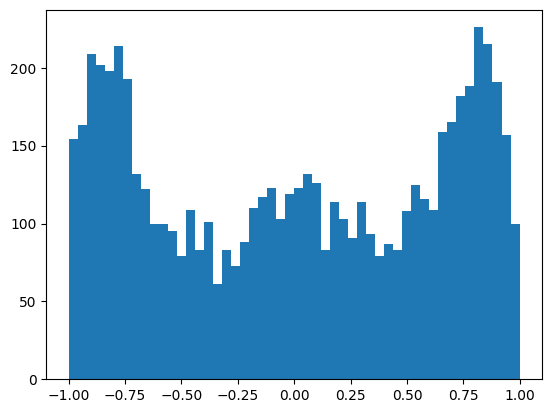

In [10]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   7.,   2.,   8.,   6.,  10.,  23.,  25.,  58.,  87.,
         92., 199., 254., 383., 388., 296., 349., 365., 538., 569., 452.,
        353., 375., 414., 364., 313., 186., 120.,  66.,  40.,  22.,  14.,
          7.,   4.,   4.,   2.,   1.,   1.]),
 array([-6.07833767, -5.88263598, -5.6869343 , -5.49123261, -5.29553093,
        -5.09982924, -4.90412756, -4.70842587, -4.51272419, -4.3170225 ,
        -4.12132082, -3.92561913, -3.72991745, -3.53421576, -3.33851408,
        -3.1428124 , -2.94711071, -2.75140903, -2.55570734, -2.36000566,
        -2.16430397, -1.96860229, -1.7729006 , -1.57719892, -1.38149723,
        -1.18579555, -0.99009386, -0.79439218, -0.59869049, -0.40298881,
        -0.20728712, -0.01158544,  0.18411625,  0.37981793,  0.57551962,
         0.7712213 ,  0.96692299,  1.16262467,  1.35832636,  1.55402804,
         1.74972973,  1.94543141,  2.1411331 ,  2.33683478,  2.53253647,
 

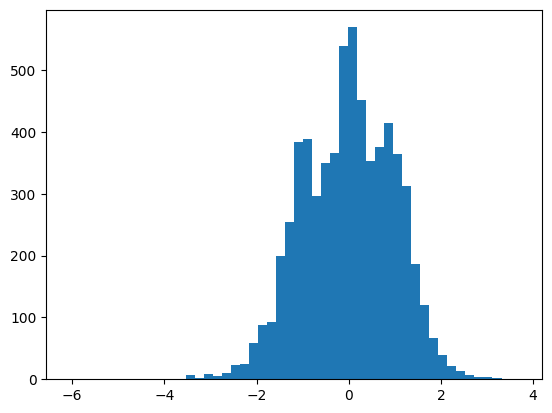

In [11]:
plt.hist(hpreact.view(-1).tolist(), 50)

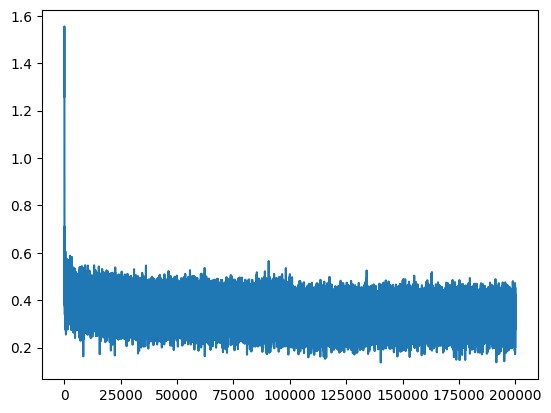

In [12]:
plt.plot(lossi)

# PyTorchi-fying the code

In [13]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #fan_in**0.5 kamming bias
        self.bias   = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps          = eps
        self.momentum     = momentum
        self.training     = True
        
        #parameter's (trained with backprop)
        self.gamma        = torch.ones(dim) 
        self.beta         = torch.zeros(dim)
        
        #buffers (trained with a running 'momentu update')
        self.running_mean = torch.zeros(dim)
        self.running_var  = torch.ones(dim)
        
    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar  = x.var(0, keepdim=True) #batch varience
        else:
            xmean = self.running_mean
            xvar  = self.running_var
            
        xhat      = (x-xmean) / torch.sqrt(xvar + self.eps) #normalize to unit varience
        self.out  = self.gamma * xhat + self.beta
        
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embd   = 10  # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g        = torch.Generator().manual_seed(2147483647) # for reproducability

C        = torch.randn((vocab_size, n_embd), generator=g)
layers   = [
            Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden),Tanh(),
            Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
            Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
            Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
            Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
            Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
            ]

with torch.no_grad():
    # last layer : make less confident
    layers[-1].gamma *= 0.1
    
    # all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

47551


In [14]:
max_steps  = 20000
batch_size = 32
lossi      = []
ud         = []

for i in range(max_steps):
    
    #minibatch construct
    ix     = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb]               #embed the characters into vectros
    x   = emb.view(emb.shape[0], -1)   # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG : would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    if i % 10000 == 0: #print every once in while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break # AFTER DEBUG : would take out obviously to run full optimization

      0/  20000: 3.287031


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

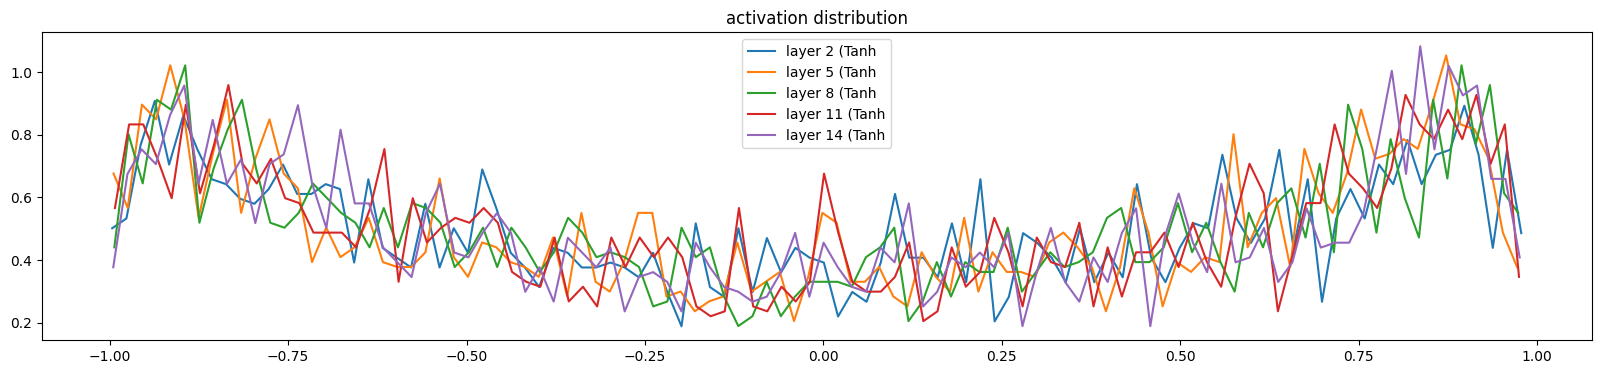

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.561990e-03
layer 5 (      Tanh): mean -0.000000, std 3.119532e-03
layer 8 (      Tanh): mean +0.000000, std 2.904410e-03
layer 11 (      Tanh): mean +0.000000, std 2.580227e-03
layer 14 (      Tanh): mean -0.000000, std 2.440871e-03


Text(0.5, 1.0, 'gradient distribution')

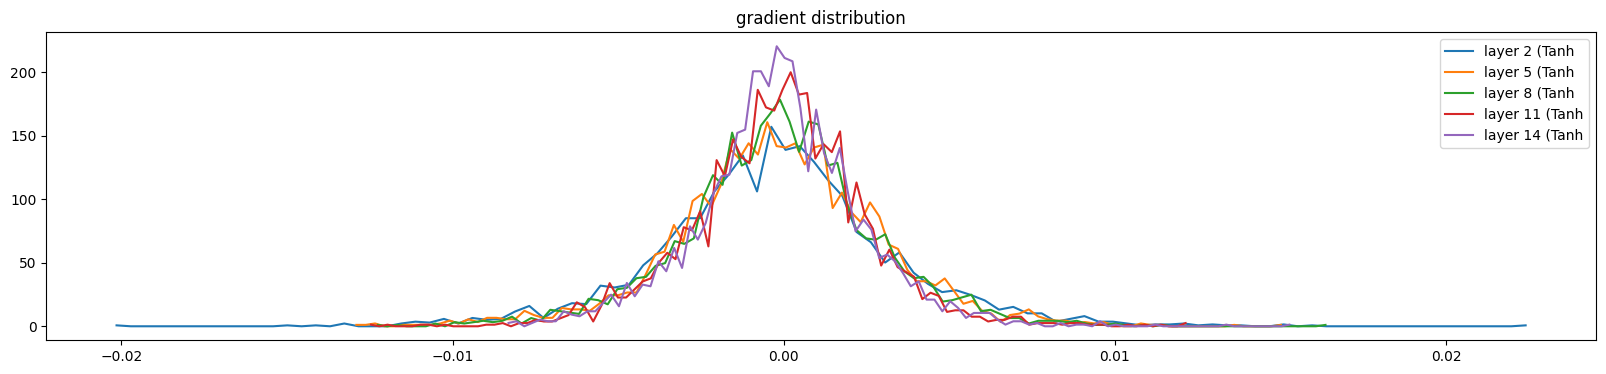

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.198672e-03 | grad:data ratio 8.190313e-03
weight  (30, 100) | mean -0.000195 | std 7.650407e-03 | grad:data ratio 2.447701e-02
weight (100, 100) | mean -0.000097 | std 6.207583e-03 | grad:data ratio 3.712882e-02
weight (100, 100) | mean +0.000015 | std 5.561924e-03 | grad:data ratio 3.297631e-02
weight (100, 100) | mean +0.000008 | std 5.220607e-03 | grad:data ratio 3.110155e-02
weight (100, 100) | mean +0.000029 | std 4.829167e-03 | grad:data ratio 2.876372e-02
weight  (100, 27) | mean -0.000014 | std 9.281224e-03 | grad:data ratio 5.568822e-02


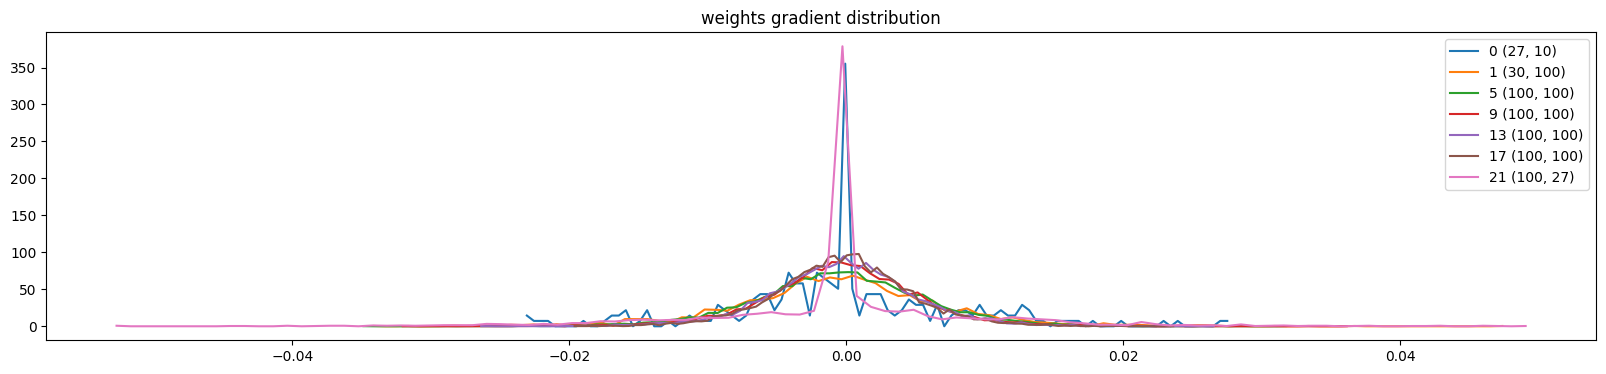

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

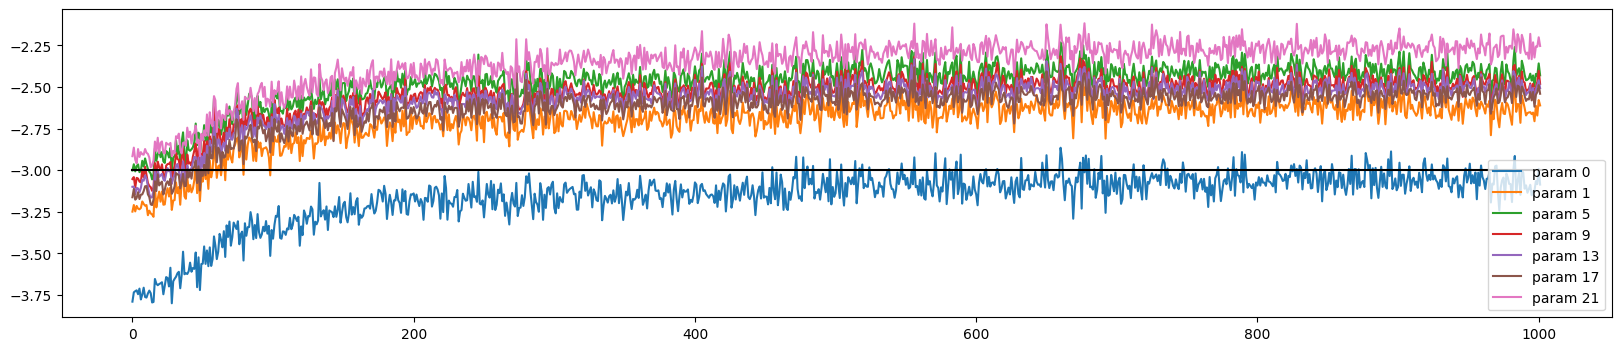

In [18]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);